---   
 <img align="left" width="75" height="75"  src="https://upload.wikimedia.org/wikipedia/en/c/c8/University_of_the_Punjab_logo.png"> 

<h1 align="center">Department of Data Science</h1>
<h1 align="center">Text Analytics: Cybercrime Detection in Pakistan.</h1>

---
<h3><div align="Center">Instructor: Dr Khurram Shahzad</div></h3>
<h3><div align="center">Instructor: Hammad Akram</div></h3>    

### Import Libraries 

In [15]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk import ngrams
import emoji
import re
import string
import preprocessor as p
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from arabic_reshaper import ArabicReshaper
import arabic_reshaper


from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics

import tensorflow 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


### Scrape data from twitter using snscraper

In [16]:
#maxTweets = 500000
maxTweets = 500

# Creating list to append tweet data to
tweets_list2 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f"#امپوڑٹڈ_حکومت_نامنظور  lang:ur").get_items()):
    if i>maxTweets:
        break
    tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    
# Creating a dataframe from the tweets list above
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

# Display first 5 entries from dataframe
tweets_df2.head()
tweets_df2.to_csv('#امپوڑٹڈ_حکومت_نامنظور.csv', sep=',', index=False)

Error retrieving https://twitter.com/search?f=live&lang=en&q=%23%D8%A7%D9%85%D9%BE%D9%88%DA%91%D9%B9%DA%88_%D8%AD%DA%A9%D9%88%D9%85%D8%AA_%D9%86%D8%A7%D9%85%D9%86%D8%B8%D9%88%D8%B1++lang%3Aur&src=spelling_expansion_revert_click: ConnectionError(MaxRetryError("HTTPSConnectionPool(host='twitter.com', port=443): Max retries exceeded with url: /search?f=live&lang=en&q=%23%D8%A7%D9%85%D9%BE%D9%88%DA%91%D9%B9%DA%88_%D8%AD%DA%A9%D9%88%D9%85%D8%AA_%D9%86%D8%A7%D9%85%D9%86%D8%B8%D9%88%D8%B1++lang%3Aur&src=spelling_expansion_revert_click (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f4639b99ee0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))"))
4 requests to https://twitter.com/search?f=live&lang=en&q=%23%D8%A7%D9%85%D9%BE%D9%88%DA%91%D9%B9%DA%88_%D8%AD%DA%A9%D9%88%D9%85%D8%AA_%D9%86%D8%A7%D9%85%D9%86%D8%B8%D9%88%D8%B1++lang%3Aur&src=spelling_expansion_revert_click failed, giving up.
Errors: ConnectionError(MaxRetryErro

ScraperException: 4 requests to https://twitter.com/search?f=live&lang=en&q=%23%D8%A7%D9%85%D9%BE%D9%88%DA%91%D9%B9%DA%88_%D8%AD%DA%A9%D9%88%D9%85%D8%AA_%D9%86%D8%A7%D9%85%D9%86%D8%B8%D9%88%D8%B1++lang%3Aur&src=spelling_expansion_revert_click failed, giving up.

### Analyze the unclean data using word cloud
    - the word cloud is created in two steps first we tokenize the string into words and then use these words to create wordcloud

In [2]:
def wordFreq(data):
    ndf = pd.DataFrame()
    final = pd.DataFrame(columns = ["word", "count"])
    for ind in data.index:
        data.loc[ind, ['length']] = len(data['Text'][ind].split())
    wordlist = []
    for ind in data.index:
        for i in data['Text'][ind].split():
            wordlist.append(i)            
    wordfreq = []
    for w in wordlist:
        wordfreq.append(wordlist.count(w))
        
    ndf['word'] = wordlist
    ndf['count'] = wordfreq
    for ind in ndf.index:
        if ndf['word'][ind] not in final.values:
            final.loc[len(final.index)] = [ndf['word'][ind], ndf['count'][ind]]  
    return final

In [3]:
tweets_df2 = pd.read_csv('#امپوڑٹڈ_حکومت_نامنظور.csv')
word_freq = wordFreq(tweets_df2)

In [14]:
def wordCloud(wordCount):   
    d = {}
    for w,c in np.array(wordCount):
        text = arabic_reshaper.reshape(w)
        text = get_display(text)
        d[text] = int(c)
    wordcloud = WordCloud(width = 800, height = 800,
             font_path='NotoNaskhArabic-Regular.ttf',
            background_color ='white',
            min_font_size = 5).generate_from_frequencies(d)
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

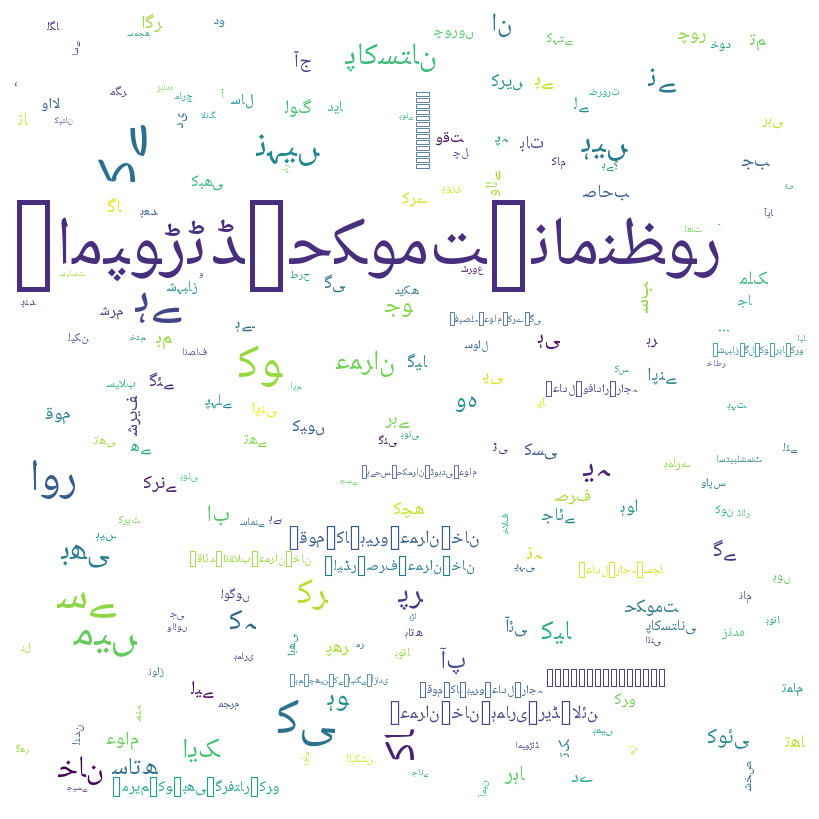

In [5]:
wordCloud(word_freq)

# Clean the scraped data

In [7]:
def clean_text(text):
    # Define the list of Punctuation marks to be removed
    punctuation = string.punctuation + "\n"

    # Define the list of non-Urdu characters to be removed
    non_urdu_characters = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ?؟۔"

    # Iterate over each character in the text
    cleaned_text = ""
    for char in text:
        if char not in punctuation and char not in non_urdu_characters:
            cleaned_text += char
    return cleaned_text

In [9]:
data = pd.read_csv('#امپوڑٹڈ_حکومت_نامنظور.csv')

for i in range(0, len(data)):
    p.set_options(p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER, p.OPT.SMILEY, p.OPT.RESERVED)
    data['Text'][i] = p.clean(data['Text'][i])


for i in range(0, len(data)):
    data['Text'][i] = emoji.demojize(data['Text'][i])

    
for i in range(0, len(data)):
     data['Text'][i] = clean_text(data['Text'][i])
        
data = data.drop_duplicates(subset='Text')
 

/tmp/ipykernel_15486/2943594432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'][i] = p.clean(data['Text'][i])
/tmp/ipykernel_15486/2943594432.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'][i] = emoji.demojize(data['Text'][i])
/tmp/ipykernel_15486/2943594432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Text'][i] = clean_text(data['Text'][i])


In [10]:
data.to_excel(r'Fully_Clean_Training.xlsx', encoding="utf-8")

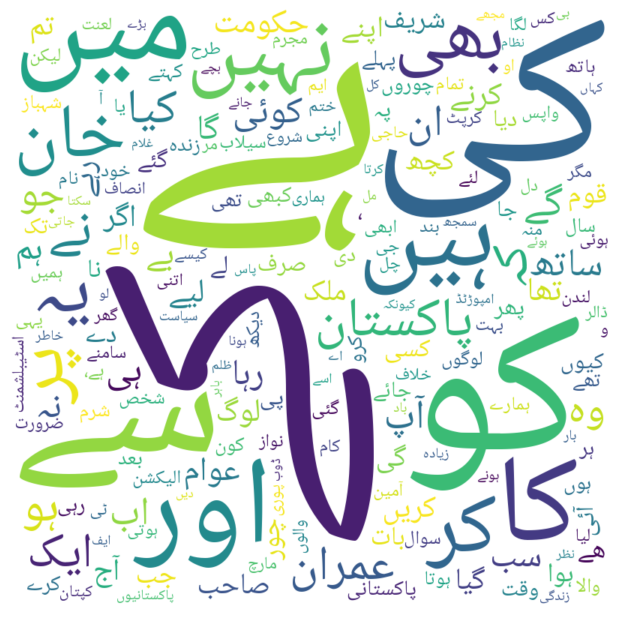

In [15]:
wc = wordFreq(data)
wordCloud(wc)

In [12]:
df = pd.read_excel("Fully_Clean_Training.xlsx")

with open('stopwords-ur.txt', 'r', encoding='utf-8') as f:
    # Read all the lines of the file as a list
    stopwords = f.readlines()
stopwords = [line.rstrip() for line in stopwords]    



df['tokens'] = df['Text'].apply(lambda x: x.split())

# Remove the stop words from the tokens list
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stopwords])

# Join the remaining tokens to form the cleaned text
df['cleaned_text'] = df['tokens'].apply(lambda x: ' '.join(x))

# Update the column in the dataframe with the cleaned text
df['Text'] = df['cleaned_text']
df = df.drop(['tokens', ], axis=1)

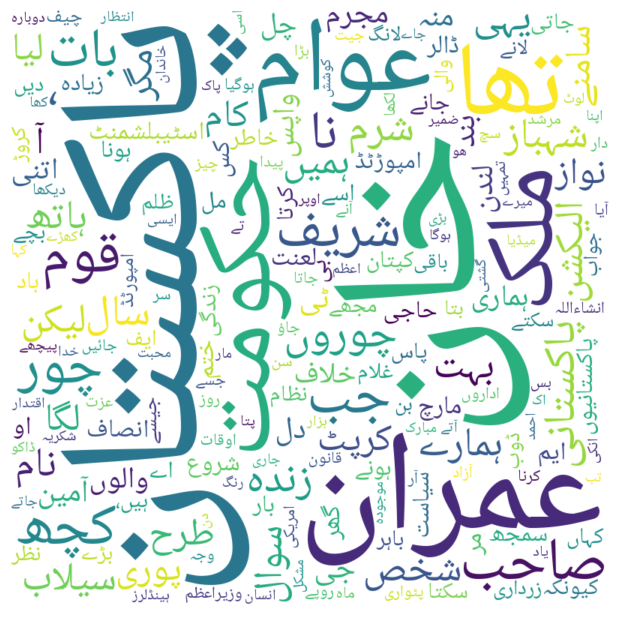

In [16]:
cleanWordFreq = wordFreq(df)

cleanWordFreq.head()
wordCloud(cleanWordFreq)

### ML Technique

In [2]:
training_dataset = pd.read_excel('training.xlsx')
test_dataset = pd.read_excel('test.xlsx')

trainX = np.array(training_dataset['Text'])
trainY = np.array(training_dataset['Label'])
testX = np.array(test_dataset['Text'])
testY = np.array(test_dataset['Label'])

In [3]:
vectTrain = CountVectorizer(input='content',decode_error='ignore',analyzer='word', binary=False, ngram_range=(1,1)).fit(trainX)
X_train_vectorized = vectTrain.transform(trainX).toarray()
X_test_vectorized = vectTrain.transform(testX).toarray()
print(X_train_vectorized)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
naivebayes = GaussianNB()
naivebayes.fit(X_train_vectorized, trainY)
testPredictionsnaivebayes = naivebayes.predict(X_test_vectorized)

In [5]:
print (metrics.classification_report(testY,testPredictionsnaivebayes))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       359
           1       0.82      1.00      0.90       295

    accuracy                           0.90       654
   macro avg       0.91      0.91      0.90       654
weighted avg       0.92      0.90      0.90       654



In [6]:
test_dataset['Naive_Bayes_Result'] = testPredictionsnaivebayes
test_dataset.to_excel('Naive_Bayes_Result.xlsx', index=False, encoding="utf-8") 

### Deep Learning 

In [7]:
c=0
max_features = 50000
maxlen = 250
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250

In [8]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(training_dataset['Text'].values)

In [9]:
trainX = tokenizer.texts_to_sequences(trainX)
testX = tokenizer.texts_to_sequences(testX)

In [10]:
trainX = sequence.pad_sequences(trainX, maxlen=maxlen)
testX = sequence.pad_sequences(testX, maxlen=maxlen)

In [11]:
#print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
    
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#print('Train...')
model.fit(trainX, trainY, batch_size=batch_size, epochs=2, validation_data=(testX, testY))

2023-02-22 09:41:12.366215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 09:41:12.366246: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 09:41:12.366314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (muhammad-ThinkPad-E15): /proc/driver/nvidia/version does not exist
2023-02-22 09:41:12.366935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 09:41:12.561993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of t

Epoch 1/2
68/68 [==============================] - 23s 318ms/step - loss: 0.6626 - accuracy: 0.6026 - val_loss: 0.5314 - val_accuracy: 0.7416
Epoch 2/2
68/68 [==============================] - 23s 333ms/step - loss: 0.3825 - accuracy: 0.8390 - val_loss: 0.1508 - val_accuracy: 0.9480


In [12]:
# predict crisp classes for test set

LSTM_test_pridict = model.predict_classes(testX, verbose=0) 
LSTM_test_pridict = LSTM_test_pridict[:, 0]

/home/muhammad/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [13]:
print (metrics.classification_report(testY,LSTM_test_pridict))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       359
           1       0.97      0.91      0.94       295

    accuracy                           0.95       654
   macro avg       0.95      0.94      0.95       654
weighted avg       0.95      0.95      0.95       654



In [14]:
test_dataset['LSTM_Result'] = LSTM_test_pridict
test_dataset.to_excel('LSTM_Result.xlsx', index=False, encoding="utf-8") 